In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import time
from sklearn.linear_model import LinearRegression
from tqdm import tqdm_notebook as tqdm
from tsfresh import extract_features
from lightgbm import LGBMRegressor

from tsfresh import extract_relevant_features

In [2]:
def smape(satellite_predicted_values, satellite_true_values): 
    # the division, addition and subtraction are pointwise 
    return np.mean(np.abs((satellite_predicted_values - satellite_true_values) 
        / (np.abs(satellite_predicted_values) + np.abs(satellite_true_values))))

In [3]:
# Загрузка данных
# windows
PATH_TO_DATA = os.path.join('../data')
full_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'), index_col='id')
full_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'), index_col='id')

In [4]:
full_train

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,2014-01-01T00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,2014-01-01T00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2014-01-01T01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,2014-01-01T02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,2014-01-01T03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234089,2014-01-31T22:00:22.602,599,-21721.485878,-14048.557595,5277.807430,-1.351754,3.373418,0.004995,-20717.958996,-16245.240500,5250.939232,-1.653931,3.157321,0.079069
1234090,2014-01-31T22:25:13.240,599,-23176.890569,-8712.016936,5153.371350,-0.575955,3.764450,-0.175109,-22673.444496,-11192.339393,5243.608790,-0.945328,3.603371,-0.092202
1234091,2014-01-31T22:50:03.878,599,-23363.044794,-2906.071320,4747.247386,0.351381,3.992943,-0.372198,-23461.830699,-5570.167175,4966.813869,-0.087089,3.912550,-0.281989


In [4]:
# from sklearn.model_selection import TimeSeriesSplit

# N_FOLDS = 5
# ts_splitter = TimeSeriesSplit(N_FOLDS)

### Важно! В train.csv и test.csv признаки `epoch` и `sat_id` стоят в разном порядке. Это может быть критично для некоторых моделей (например, lgbm). Поэтому сделаем единный порядок:

In [5]:
test_cols = list(full_test.columns)
test_cols[0] = 'epoch'
test_cols[1] = 'sat_id'
full_test = full_test.reindex(columns=test_cols)

In [6]:
full_train['epoch'] = full_train.epoch.apply(lambda x: time.mktime(datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f').timetuple())).values
full_test['epoch'] = full_test.epoch.apply(lambda x: time.mktime(datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f').timetuple())).values

In [7]:
full_train.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,1.388520e+09,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1.388523e+09,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,1.388526e+09,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,1.388528e+09,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,1.388531e+09,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [8]:

# kind_to_fc_parameters = {
#     "x_sim": {"mean": None},#, "max": None, "min": None},
#     "y_sim": {"mean": None},#, "max": None, "min": None},
#     "z_sim": {"mean": None},#, "max": None, "min": None},
#     "Vx_sim": {"mean": None},#, "max": None, "min": None},
#     "Vy_sim": {"mean": None},#, "max": None, "min": None},
#     "Vz_sim": {"mean": None}#, "max": None, "min": None},
    
# }

# extracted_features = extract_features(full_train, kind_to_fc_parameters=None,
#                                       column_id="sat_id", column_sort="epoch")

In [9]:
# import pickle

In [10]:
# with open('timeseries_features', 'wb') as handle:
#     pickle.dump(extracted_features, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
# extracted_features

In [12]:
full_train.head()

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
id,,,,,,,,,,,,,,
0,1.388520e+09,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1.388523e+09,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,1.388526e+09,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,1.388528e+09,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,1.388531e+09,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [13]:
# x_num

for i, col in enumerate(['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']):
    full_train[col + '_num'] = 0
    arr = full_train[col + '_num'].values
    start = 0
    for sat_id in range(600):
        df = full_train[full_train.sat_id == sat_id]
        step = df.shape[0]
        idx_min = df[col].idxmin() % 24
        arr[start: start + step] = np.fromfunction(lambda i: (i + idx_min) % 24, (step, ))
        start += step
    full_train[col + '_num'] = arr

In [14]:
# x_num

for i, col in enumerate(['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']):
    full_test[col + '_num'] = 0
    arr = full_test[col + '_num'].values
    start = 0
    for sat_id in full_test.sat_id.unique():
        df = full_test[full_test.sat_id == sat_id]
        step = df.shape[0]
        idx_last = full_train[full_train.sat_id == sat_id][col + '_num'].iloc[-1] + 1
        arr[start: start + step] = np.fromfunction(lambda i: (i + idx_last) % 24, (step, ))
        start += step
    full_test[col + '_num'] = arr
        

In [15]:
for col_name in ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']:
    full_test[col_name] = 0.0

In [29]:
%%time

features_for_tsfresh = ['sat_id', 'epoch', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']
target_cols = ['x', 'y', 'z', 'Vx', 'Vy', 'Vz']

width = 8
for sat_id in tqdm(full_test.sat_id.unique()):
    df1_train = full_train[full_train.sat_id == sat_id]
    df1_test =  full_test[full_test.sat_id == sat_id]
    for col in target_cols:
        for i in range(24):
            df2_train = df1_train[df1_train[col + '_sim_num'] == i]
            df2_test = df1_test[df1_test[col + '_sim_num'] == i]
            
            
            
            
            lin_model = LGBMRegressor(n_jobs=16)
            X_train = df2_train.reset_index().drop(columns=target_cols).tail(width)
            y_train = df2_train[col].values[-width:]
            
            train_features = extract_features(X_train[features_for_tsfresh], kind_to_fc_parameters=None,
                                              column_id="sat_id", column_sort="epoch")
            
            
            tmp = np.zeros((X_train.shape[0], train_features.size))
            tmp = train_features.values + tmp
            X_train = pd.concat([X_train, pd.DataFrame(tmp, index=X_train.index)], axis=1).values
            
            
            
            lin_model.fit(X_train, y_train)
            
            X_test = df2_test.reset_index().drop(columns=target_cols).tail(width)
            test_features = extract_features(X_test[features_for_tsfresh], kind_to_fc_parameters=None,
                                             column_id="sat_id", column_sort="epoch")
            tmp = np.zeros((X_test.shape[0], test_features.size))
            tmp = test_features.values + tmp
            X_test = pd.concat([X_test, pd.DataFrame(tmp, index=X_test.index)], axis=1).values
            
            y_test = lin_model.predict(X_test)
            
            
            full_test.loc[X_test[:, 0].ravel(), col] = y_test

/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.01it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.67it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.48it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 94.61it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.87it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 27.90it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.39it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.57it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.83it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.86it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.41it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 20.34it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.59it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.89it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.24i

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.76it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.23it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.70it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.29it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.11it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.67it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.18it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 93.95it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.79it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.59it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.02it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.69it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.91it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.83it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.54it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 23.20it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.42it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.13it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 22.48it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 35.74it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.02it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.95it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.66it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 82.79it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.49it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.53it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.91it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.67it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 83.95it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.49it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 98.57it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.75it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.65it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.12it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.92it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.85it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.32it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.53it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.98it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.68it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.58it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.56it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.49it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.51it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.56it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.05it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.11it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.69it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.64it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.65it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.41it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.54it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.85it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.94it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.49it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.65it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.88it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.99it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.77it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.31it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.27it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.91it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.09it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.08it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.99it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.58it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 97.51it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.85it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.48it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.46it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.74it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.99it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.16it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.35it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.49it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.44it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.13it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 82.01it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.64it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.06it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.17it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 82.21it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.82it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.54it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 83.86it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.84it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.30it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.84it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.98it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 82.89it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.64it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.54it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.16it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.22it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.25it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.68it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.22it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.89it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.83it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.29it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.82it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.03it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.73it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.37it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.83it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.47it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.52it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.57it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.50it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.68it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.69it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.25it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.84it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.49it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.69it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.09it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.78it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.48it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.66it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.97it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.60it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.96it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.10it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.60it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.93it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.13it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 83.85it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.51it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 83.69it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.30it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.67it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.45it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.70it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.39it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.56it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.01it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.70it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 23.28it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.87it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.13it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 23.05it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.92it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.39it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 23.41it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.64it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.61it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 22.14it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 35.35it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.70it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.70it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.36it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.02it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.60it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.79it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.27it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.97it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.93it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.44it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.82it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.16it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.91it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.41it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.23it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.60it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.56it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.90it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.31it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.45it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.51it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.68it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 35.98it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.12it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.03it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.62it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.88it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.73it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.22it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.95it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.02it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.47it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.05it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.41it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.72it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.94it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.36it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.37it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.70it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 82.19it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 83.05it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.79it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 83.57it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.56it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.38it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.92it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.09it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 94.32it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.80it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.75it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 105.43it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.36it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.68it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.96it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 93.05it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 94.29it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.10it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 93.88it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 95.39it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.73it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 93.61it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.16i

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.89it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.16it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.35it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.47it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.56it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 94.40it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.05it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 95.28it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.89it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.28it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.79it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.99it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.03it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.90it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 93.59it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.01it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.04it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.67it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.54it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.09it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.33it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.88it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.68it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.50it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 94.82it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.59it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.72it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.71it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.61it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.76it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.31it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.53it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.21it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.72it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.93it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 82.10it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.49it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.82it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.44it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.89it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.53it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.57it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.02it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.71it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.60it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.21it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.20it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.51it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.20it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 28.19it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.95it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 93.62it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.95it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.27it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.04it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 30.80it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 83.10it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.22it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.23it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.27it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.98it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.78it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.92it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.10it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.04it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.18it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 93.71it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.51it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.50it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.81it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 117.67it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.97it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 81.99it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 81.43it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 92.08i

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 23.92it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 121.98it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.10it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 23.15it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 82.79it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.47it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 23.23it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 84.47it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.90it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 16.49it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.16it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.09it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.75it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.07it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.90i

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.21it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.80it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.13it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.08it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.26it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.32it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.39it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.90it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.16it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 98.77it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.04it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.31it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.28it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.12it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 87.18it

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 118.44it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.21it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 115.01it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.21it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 108.90it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.31it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 107.86it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.15it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 102.85it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.22it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 95.45it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.49it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 98.50it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.47it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 11

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.23it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 93.25it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.28it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 90.19it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 86.32it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 91.00it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.22it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.88it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.41it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.01it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.31it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.58it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 85.18it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 89.07it/s]

Feature Extraction: 100%|██████████| 6/6 [00:00<00:00, 88.87it

  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()



KeyboardInterrupt: 

  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/hom

In [17]:
full_test[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']].to_csv('submission.csv', index_label='id')

In [23]:
np.array([1, 2, 3, 4, 5])[-3:]

array([3, 4, 5])

In [37]:
import tsfresh

tsfresh.utilities.dataframe_functions.roll_time_series(full_train[:500],
                                                       column_id='sat_id',
                                                       column_sort='epoch',
                                                       column_kind=None,
                                                       rolling_direction=1,
                                                       )

,epoch,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,x_sim_num,y_sim_num,z_sim_num,Vx_sim_num,Vy_sim_num,Vz_sim_num,sat_id
124750,1.388520e+09,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,2.0,7.0,1.0,22.0,1.0,22.0,1.388520e+09
124251,1.388520e+09,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,2.0,7.0,1.0,22.0,1.0,22.0,1.388523e+09
124751,1.388523e+09,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,3.0,8.0,2.0,23.0,2.0,23.0,1.388523e+09
123753,1.388520e+09,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,2.0,7.0,1.0,22.0,1.0,22.0,1.388526e+09
124252,1.388523e+09,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,3.0,8.0,2.0,23.0,2.0,23.0,1.388526e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123255,1.389905e+09,17215.142577,-9984.764690,39987.970093,0.144807,2.570873,0.261821,17254.013940,-2159.705460,39942.535214,-0.093999,2.656234,-0.292213,17.0,22.0,16.0,13.0,16.0,13.0,1.389916e+09
123752,1.389907e+09,17310.834107,-2643.573637,40002.508135,-0.079269,2.652288,-0.257349,16656.521105,5278.457680,38351.239800,-0.334985,2.633190,-0.848647,18.0,23.0,17.0,14.0,17.0,14.0,1.389916e+09
124250,1.389910e+09,16755.712363,4793.167619,38513.121073,-0.319417,2.636281,-0.810849,15362.891638,12489.852073,35157.091581,-0.590258,2.490161,-1.434710,19.0,0.0,18.0,15.0,18.0,15.0,1.389916e+09
124749,1.389913e+09,15506.578238,12025.414842,35428.609329,-0.574040,2.502218,-1.394414,13338.504697,19097.425823,30290.768938,-0.855262,2.196297,-2.038993,20.0,1.0,19.0,16.0,19.0,16.0,1.389916e+09


In [48]:
tmp = tsfresh.utilities.dataframe_functions.make_forecasting_frame(full_train['x'][:500].values,
                                                             kind='regression',
                                                             rolling_direction=1,
                                                             max_timeshift = 5
                                                       )

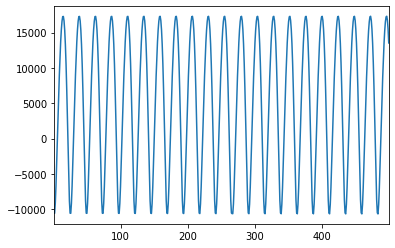

In [55]:
tmp[1].plot()

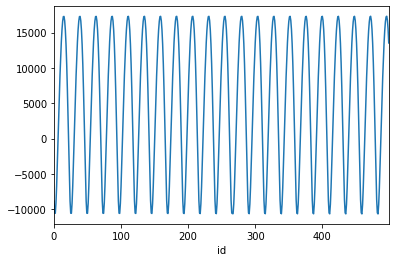

In [56]:
full_train['x'][:500].plot()

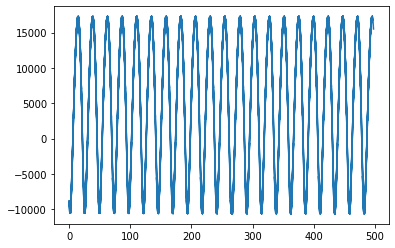

In [63]:
plt.plot(tmp[0]['time'], tmp[0]['value'])

In [64]:
full_train

,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim,x_sim_num,y_sim_num,z_sim_num,Vx_sim_num,Vy_sim_num,Vz_sim_num
id,,,,,,,,,,,,,,,,,,,,
0,1.388520e+09,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133,2,7,1,22,1,22
1,1.388523e+09,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468,3,8,2,23,2,23
2,1.388526e+09,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768,4,9,3,0,3,0
3,1.388528e+09,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306,5,10,4,1,4,1
4,1.388531e+09,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237,6,11,5,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234089,1.391191e+09,599,-21721.485878,-14048.557595,5277.807430,-1.351754,3.373418,0.004995,-20717.958996,-16245.240500,5250.939232,-1.653931,3.157321,0.079069,3,20,12,20,13,8
1234090,1.391193e+09,599,-23176.890569,-8712.016936,5153.371350,-0.575955,3.764450,-0.175109,-22673.444496,-11192.339393,5243.608790,-0.945328,3.603371,-0.092202,4,21,13,21,14,9
1234091,1.391194e+09,599,-23363.044794,-2906.071320,4747.247386,0.351381,3.992943,-0.372198,-23461.830699,-5570.167175,4966.813869,-0.087089,3.912550,-0.281989,5,22,14,22,15,10
